In [1]:
import h5py
import pandas as pd
import os
import numpy as np
import datetime
import tensorflow as tf
import time
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

SAVE_PATH = '/ws_data/CWB/precipitation/raw'
TARGET_FILESIZE = 150*1024*1024 # 150MB
NUM_RECORDS = TARGET_FILESIZE/(55*55*4*7)
print(f'NUM_RECORDS: {NUM_RECORDS}')

f = h5py.File(os.path.join(SAVE_PATH, 'raw.hdf5'), 'r') # (default: rdcc_nbytes=1*1024**2, rdcc_nslots=512)
COL_NAMES = list(f.keys())
print(f'COL_NAMES: {COL_NAMES}')

# # 6 == 00-00-00, 00-10-00, 00-20-00, 00-30-00, 00-40-00, 00-50-00 are missing
# print(len(f['rain_Ali_mountain/2017/04/01'].keys()) - 6*24)

NUM_RECORDS: 1856.982290436836
COL_NAMES: ['Ali_mountain', 'BaoZhong', 'Hualien', 'Kanding', 'SanHua', 'Taichung', 'Taipei', 'Taitung', 'Taoyuan']


In [2]:
f['Ali_mountain'].keys()

<KeysViewHDF5 ['height', 'lat', 'lon', 'rain']>

In [35]:
tally = []
for s in f:
    tally.append(f[f'{s}/lon'][:])

tally = np.concatenate(tally)
sns.distplot(tally)
print(tally.mean(), tally.max(), tally.min())

120.92084 121.9 120.025


23.329166 25.35 21.7


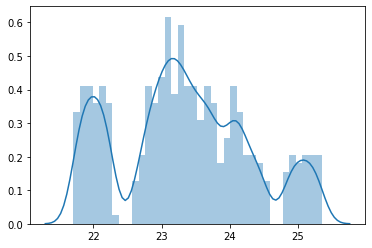

In [34]:
tally = []
for s in f:
    tally.append(f[f'{s}/lat'][:])

tally = np.concatenate(tally)
sns.distplot(tally)
print(tally.mean(), tally.max(), tally.min())

0.19626452 1.1899084 -1.0


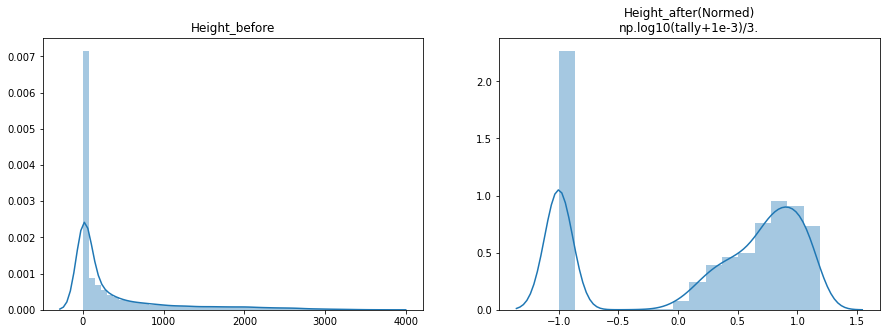

In [7]:
tally = []
for s in f:
    tally.append(f[f'{s}/height'][:])

tally = np.concatenate(tally)
tally[tally<0.] = 0
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Height_before')
sns.distplot(tally)
plt.subplot(1,2,2)
plt.title('Height_after(Normed)\nnp.log10(tally+1e-3)/3.')
tally = np.log10(tally+1e-3)/3.
sns.distplot(tally)
print(tally.mean(), tally.max(), tally.min())

In [16]:
cities = list(f.keys())

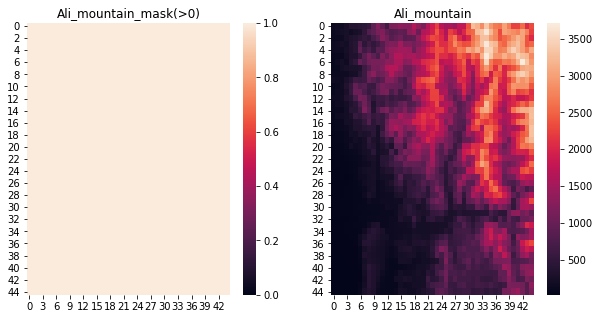

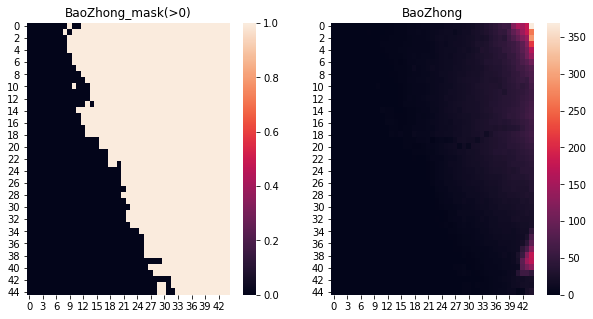

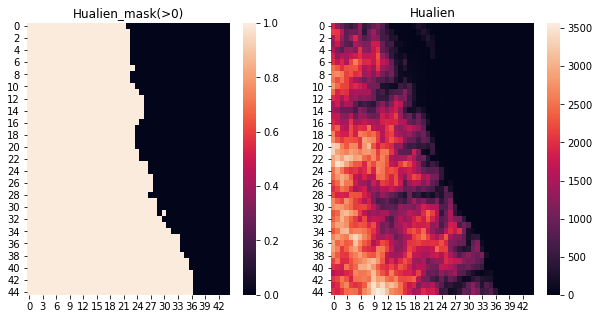

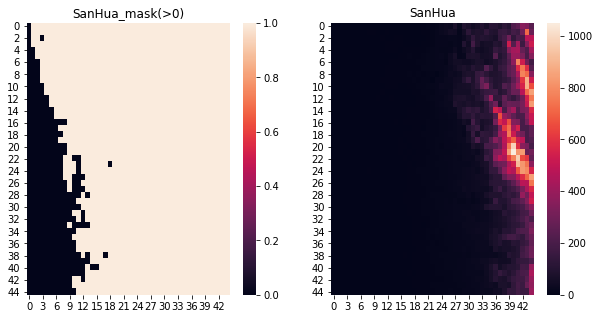

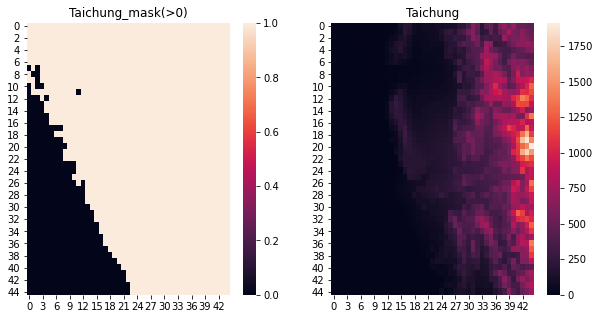

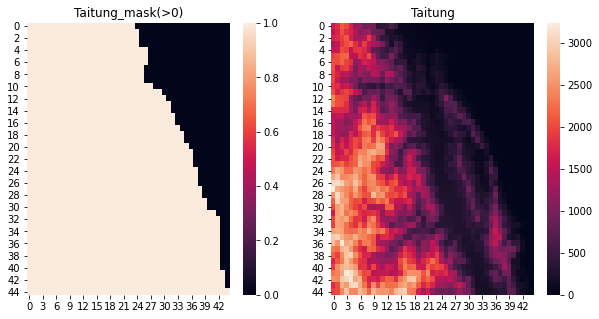

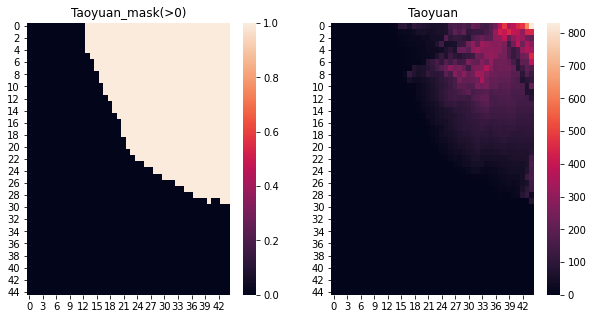

In [33]:
for s in f:
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title(f'{s}_mask(>0)')
    tmp = f[f'{s}/height'][:]
    sns.heatmap(tmp>0, vmin=0, vmax=1)
    plt.subplot(1,2,2)
    plt.title(f'{s}')
    tmp[tmp<0] = 0
    sns.heatmap(tmp)

<AxesSubplot:>

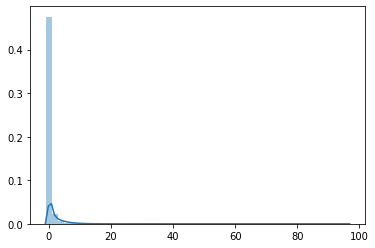

In [2]:
tally = []
for k2 in tqdm(f['Taipei/rain/2017/04/']):
    for k1 in f['Taipei/rain/2017/04/'][k2]:
        tmp = f['Taipei/rain/2017/04/'][k2][k1][:]
#         tmp = tmp[tmp>0]
        tally.append(tmp)
tally = np.concatenate(tally)
sns.distplot(tally, kde=False)

<AxesSubplot:>

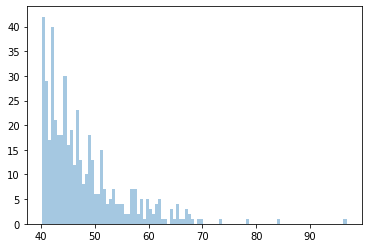

In [8]:
sns.distplot(tally[tally>40], kde=False, bins=100)

04
05
06
07
08
09



<AxesSubplot:>

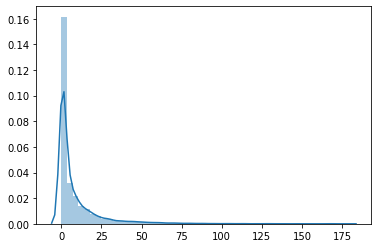

In [13]:
tally = []
for k3 in tqdm(f['Taipei/rain/2017']):
    print(k3)
    for k2 in f[f'Taipei/rain/2017/{k3}']:
        for k1 in f[f'Taipei/rain/2017/{k3}/{k2}']:
            tmp = f[f'Taipei/rain/2017/{k3}/{k2}/{k1}'][:]
    #         tmp = tmp[tmp>0]
            tally.append(tmp.max())
tally = np.array(tally)
sns.distplot(tally)

In [20]:
print(tally.max(), tally.min())

177.75 0.0


In [56]:
sns.distplot(tally, bins=170, kde=False)

<AxesSubplot:>

In [34]:
tally2 = np.tanh(np.log(tally+1e-2)/4.) 
bins = 50
sns.distplot(tally2,bins=bins)
print(tally2.max(), tally2.min())

0.8604586 -0.8181818


In [35]:
def denorm(v):
    return np.exp(np.arctanh(v)*4.)-1e-2

In [36]:
denorm(tally2.max()), denorm(tally2.min())

(177.74998241925712, -6.395087150806722e-10)

In [37]:
stride = (tally2.max() - tally2.min())/bins
for v in range(bins):
    tmp = tally2.min()+(v+1)*stride
    print(tmp, denorm(tmp), np.count_nonzero(np.logical_and(tally2<tmp, tally2>tmp-stride)))

-0.7846090054512024 0.004566959836330783 0
-0.7510361981391906 0.01021539196773843 0
-0.7174633908271789 0.017062909204741322 0
-0.6838905835151672 0.02524091123210981 0
-0.6503177762031556 0.03489644515467185 0
-0.6167449688911438 0.046194355301069655 0
-0.5831721615791321 0.059319774796411796 0
-0.5495993542671204 0.07448102130868434 0
-0.5160265469551086 0.09191297234413259 0
-0.4824537396430969 0.11188101147987527 0
-0.4488809323310852 0.13468565677741035 0
-0.4153081250190735 0.16066800735200448 0
-0.38173531770706176 0.1902161750234887 0
-0.3481625103950501 0.22377290689944895 0
-0.31458970308303835 0.2618446539507959 2252
-0.2810168957710266 0.3050124031868016 0
-0.2474440884590149 0.35394467099006954 0
-0.21387128114700316 0.4094131579869627 0
-0.18029847383499142 0.4723116988744606 0
-0.1467256665229797 0.5436793139290208 2785
-0.11315285921096807 0.6247283962453895 0
-0.07958005189895634 0.7168793691287045 0
-0.04600724458694461 0.8218035480625092 1640
-0.012434437274932875 0


-0.034772642 0.43160027 -0.14625667


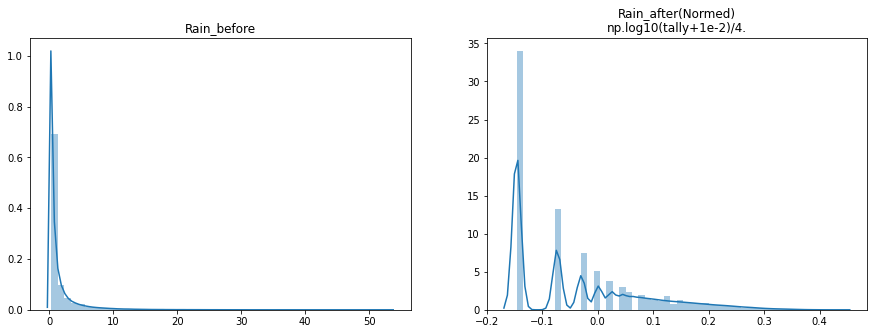

In [8]:
tally = []
for k2 in tqdm(f['BaoZhong/rain/2017/04/']):
    for k1 in f['BaoZhong/rain/2017/04/'][k2]:
        tmp = f['BaoZhong/rain/2017/04/'][k2][k1][:]
        tmp = tmp[tmp>0]
        tally.append(tmp)
tally = np.concatenate(tally)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Rain_before')
sns.distplot(tally)
plt.subplot(1,2,2)
plt.title('Rain_after(Normed)\nnp.log10(tally+1e-2)/4.')
tally = np.log(tally+1e-2)/4. 
sns.distplot(tally)
print(tally.mean(), tally.max(), tally.min())

In [5]:
for k3 in tqdm(f[f'BaoZhong/rain/2017/']):
    for k1 in f[f'BaoZhong/rain/2017/{k3}/']:
        for k2 in f[f'BaoZhong/rain/2017/{k3}/{k1}']:
            tmp = f[f'BaoZhong/rain/2017/{k3}/{k1}/{k2}'][:]
            if tmp.min()<0:
                print(tmp[tmp<0])

[-1. -1. -1. ... -1. -1. -1.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. 